In [1]:
#import packages
from time import time
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE, KMeansSMOTE
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.metrics import precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
import tensorflow as tf
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
# from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
'''stop_words = stopwords.words('english')'''
from sklearn.metrics import precision_recall_fscore_support

In [2]:
#reading data
df = pd.read_csv("fake_job_postings.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [3]:
#Function to preprocess
# df['text']=df['text'].str.lower()
def preprocess(df):
    df = df[df.location.notnull()]
    df= df[df.location.str.contains("US,")] 
    df['description']=df['description'].str.lower()
    return df

df = preprocess(df) 

In [4]:
#Appending Craiglist Scraped Data to our Aegan Dataset

df = df[['description', 'fraudulent']]
df_scraped = pd.read_csv("scraped_data.csv")
df_scraped['description'] = df_scraped['title'] + df_scraped['description']
df_scraped = df_scraped[['description', 'fraudulent']]

In [5]:
len(df)

10593

In [6]:
#lemmatiaztion
def getLemmText(text):
    tokens=word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens=[lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['description'] = list(map(getLemmText,df['description']))

In [7]:
def getStemmText(text):
    tokens=word_tokenize(text)
    ps = PorterStemmer()
    tokens=[ps.stem(word) for word in tokens]
    return ' '.join(tokens)

df['description'] = list(map(getStemmText,df['description']))
df_text = pd.DataFrame({'label': df.fraudulent.tolist() , 'description': df.description.tolist()})
df_text

,label,description
0,0,"food52 , a fast-grow , jame beard award-win on..."
1,0,"our client , locat in houston , is activ seek ..."
2,0,the compani : esri – environment system resear...
3,0,job titl : item review managerloc : fort worth...
4,0,job overviewapex is an environment consult fir...
...,...,...
10588,0,flite 's saa display ad platform fuel the worl...
10589,0,respons : will facilit the recruit and hire pr...
10590,0,"sr , javascript develop experi : 4-10 year loc..."
10591,0,the payrol account will focu primarili on payr...


In [8]:
df_text['description']= df_text['description'].astype(str)

In [9]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10593 entries, 0 to 10592
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        10593 non-null  int64 
 1   description  10593 non-null  object
dtypes: int64(1), object(1)
memory usage: 165.6+ KB


In [10]:
#Loading Glove Embedding
embeddings_index = {}
f = open('glove.6B.50d.txt', encoding='utf8')
for line in tqdm(f):
    value = line.split()
    word = value[0]
    coef = np.asarray(value[1:], dtype='float32')
    embeddings_index[word] = coef
f.close()
print(len(embeddings_index))

400000it [00:12, 33326.47it/s]

400000


In [11]:
VOCABULARY_SIZE = 2000
MAX_LENGTH = 60

In [12]:
train_x, test_x, train_y, test_y = train_test_split(df_text.description, df_text.label, test_size=0.2, random_state=0)

In [13]:
test_x.shape

(2119,)

In [14]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(train_x) + list(test_x))

xtrain_sequence = tokenizer.texts_to_sequences(train_x)
xtest_sequence = tokenizer.texts_to_sequences(test_x)

xtrain_padding = sequence.pad_sequences(xtrain_sequence, maxlen=MAX_LENGTH)
xtest_padding = sequence.pad_sequences(xtest_sequence, maxlen=MAX_LENGTH)
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, 50))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|████████████████████████████████████████████████████████████████████████| 36458/36458 [00:00<00:00, 382391.17it/s]


In [15]:
#SMOTE oversample
def smote(train_x, train_y):
    smt = KMeansSMOTE(random_state=42, k_neighbors = 72, cluster_balance_threshold = 0.05)
    train_x,train_y = smt.fit_resample(train_x,train_y)
    return train_x,train_y

train_x,train_y = smote(xtrain_padding,train_y)


In [16]:
train_x.shape

(15766, 60)

In [17]:
#LSTM
max_features=VOCABULARY_SIZE
maxlen=MAX_LENGTH
model = Sequential()
# model.add(Embedding(max_features, 40, input_length=maxlen))
model.add(Embedding(len(word_index) + 1,50,weights=[embedding_matrix],input_length=MAX_LENGTH,trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
history = model.fit(train_x, y=train_y, batch_size=64, epochs=20, verbose=1, validation_data=(xtest_padding,test_y ))

Epoch 1/20
247/247 [==============================] - 80s 274ms/step - loss: 0.5779 - accuracy: 0.6865 - val_loss: 0.3643 - val_accuracy: 0.8655
Epoch 2/20
247/247 [==============================] - 69s 281ms/step - loss: 0.4351 - accuracy: 0.7998 - val_loss: 0.5513 - val_accuracy: 0.7296
Epoch 3/20
247/247 [==============================] - 69s 281ms/step - loss: 0.3591 - accuracy: 0.8458 - val_loss: 0.2634 - val_accuracy: 0.9198
Epoch 4/20
247/247 [==============================] - 99s 401ms/step - loss: 0.3125 - accuracy: 0.8676 - val_loss: 0.2662 - val_accuracy: 0.9169
Epoch 5/20
247/247 [==============================] - 111s 451ms/step - loss: 0.2776 - accuracy: 0.8898 - val_loss: 0.4044 - val_accuracy: 0.8584
Epoch 6/20
247/247 [==============================] - 115s 465ms/step - loss: 0.2588 - accuracy: 0.8969 - val_loss: 0.3547 - val_accuracy: 0.8697
Epoch 7/20
247/247 [==============================] - 104s 422ms/step - loss: 0.2408 - accuracy: 0.9061 - val_loss: 0.2777 - val

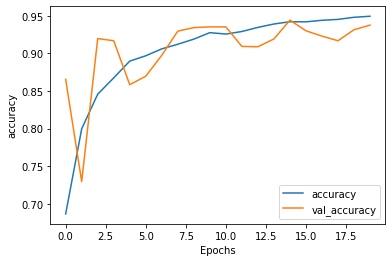

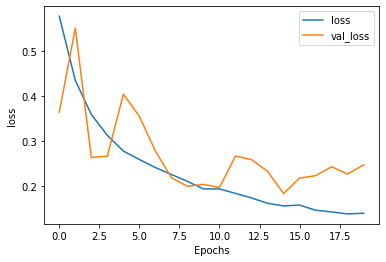

In [19]:
#Model Evaluation
def graph_plots(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

graph_plots(history, "accuracy")
graph_plots(history, 'loss')

In [20]:
train_x.shape

(15766, 60)

In [21]:
y_pred = model.predict(xtest_padding)

In [22]:
print(precision_recall_fscore_support(test_y, y_pred.round(),average='micro'))

(0.9377064653138273, 0.9377064653138273, 0.9377064653138273, None)
